In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN

# IBM Cloud Imports (To musisz doinstalować: pip install qiskit-ibm-runtime)
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit import transpile  # <--- WAŻNY NOWY IMPORT

In [6]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# Cechy PCA - tyle kubitów
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [7]:
def load_patient_data(patiend_id):
    # Wczytuje sygnał i wycina uderzenia na podstawie adnotacji
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # wczytywanie sygnału ekg dla pacjenta, szukam po tej kolumnie MLII
    df_ekg = pd.read_csv(ekg_file)
    # Usuwamy spacje z nazw kolumn (częsty błąd w CSV)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # Jeśli nie ma nazw, bierzemy kolumnę indeks 1 (bo 0 to zazwyczaj czas/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Czyścimy nazwy
            
        # Szukamy odpowiednich kolumn (sample = pozycja, symbol = typ)
        # Czasami nazywają się 'sample', 'Sample', 'time', etc.
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Nie znaleziono kolumn 'sample' lub 'symbol' w adnotacjach.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'blad {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Pomijamy uderzenia na samym początku lub końcu nagrania
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Wycinek
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Upewniamy się, że długość jest idealna
        if len(window) != WINDOW_SIZE:
            continue

        # Klasyfikacja
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Znaleziono: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly

>>> KROK 2: Wczytywanie danych testowych (Mieszane)...
  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly

STATUS DANYCH SUROWYCH:
Wymiar pojedynczego uderzenia: 90 próbek
Liczba próbek Train (Normal): 1299
Liczba próbek Test (Normal): 1200
Liczba próbek Test (Anomaly): 964

>>> KROK 3: Redukcja wymiaru (PCA) z 90 do 8...
Wyjaśniona wariancja (ile info zachowaliśmy): 99.48%
>>> KROK 4: Skalowanie do zakresu (0, pi)...
Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib

>>> KROK 5: Zapisywanie plików .npy...
GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.

>>> Generowanie wykresu kontrolnego...


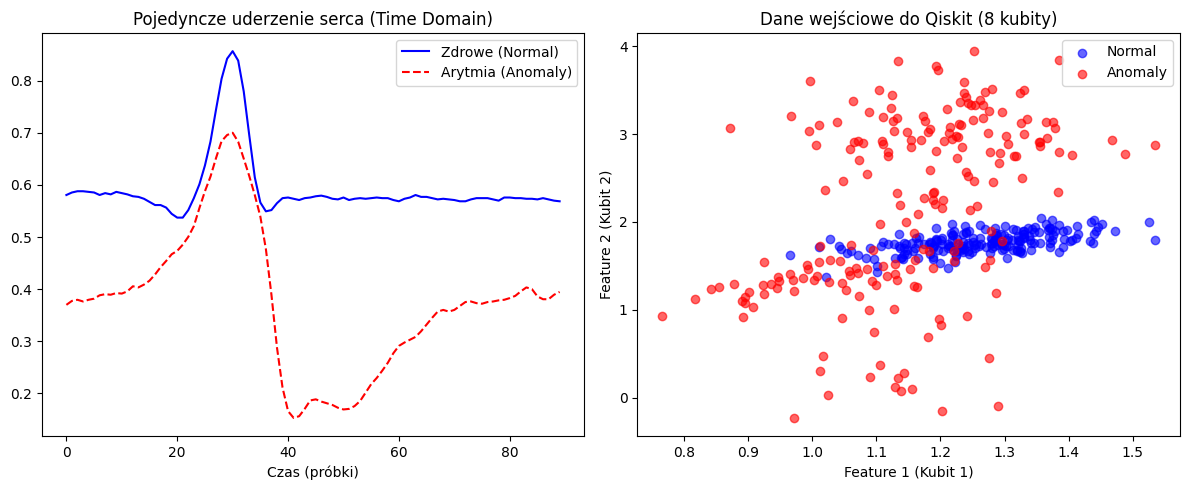

In [8]:
# --- ZBIERANIE DANYCH ---
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> KROK 2: Wczytywanie danych testowych (Mieszane)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Konwersja na numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nSTATUS DANYCH SUROWYCH:")
print(f"Wymiar pojedynczego uderzenia: {WINDOW_SIZE} próbek")
print(f"Liczba próbek Train (Normal): {X_train.shape[0]}")
print(f"Liczba próbek Test (Normal): {X_test_normal.shape[0]}")
print(f"Liczba próbek Test (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("BŁĄD KRYTYCZNY: Brak danych treningowych. Sprawdź nazwy plików CSV!")
    raise ValueError

# --- PRZETWARZANIE (PCA) ---
print(f"\n>>> KROK 3: Redukcja wymiaru (PCA) z {WINDOW_SIZE} do {N_DIM}...")

# 1. Trenujemy PCA tylko na zdrowych danych treningowych
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# 2. Transformujemy wszystkie zbiory
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# Obsługa przypadku, gdyby nie było anomalii (żeby kod nie padł)
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Wyjaśniona wariancja (ile info zachowaliśmy): {sum(pca.explained_variance_ratio_):.2%}")

# --- SKALOWANIE DO KOMPUTERA KWANTOWEGO ---
# Qiskit lubi dane w zakresie (0, pi) lub (-1, 1). 
# Użyjemy (0, pi) pod bramki rotacji.
print(">>> KROK 4: Skalowanie do zakresu (0, pi)...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Uczymy skaler na treningu

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "ibm_preprocessing_8dim.joblib"
)
print("Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# --- ZAPISYWANIE ---
print("\n>>> KROK 5: Zapisywanie plików .npy...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.")

# --- WIZUALIZACJA ---
print("\n>>> Generowanie wykresu kontrolnego...")
plt.figure(figsize=(12, 5))

# Wykres 1: Jak wygląda surowe uderzenie?
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Zdrowe (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arytmia (Anomaly)', color='red', linestyle='--')
plt.title("Pojedyncze uderzenie serca (Time Domain)")
plt.xlabel("Czas (próbki)")
plt.legend()

# Wykres 2: Jak to wygląda po PCA?
plt.subplot(1, 2, 2)
# Rysujemy tylko po 100 kropek żeby było czytelnie
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Dane wejściowe do Qiskit ({N_DIM} kubity)")
plt.xlabel("Feature 1 (Kubit 1)")
plt.ylabel("Feature 2 (Kubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> 1. Wczytywanie danych (8 cech)...
    Trening na: 1299 próbkach
>>> 2. Budowanie obwodu (8 kubitów)...
>>> 3. Start treningu (Optimizer: SPSA, Iter: 100)...
    Iter 10: Koszt = 0.4865
    Iter 20: Koszt = 0.5817
    Iter 30: Koszt = 0.5295
    Iter 40: Koszt = 0.4823
    Iter 50: Koszt = 0.4766
    Iter 60: Koszt = 0.2764
    Iter 70: Koszt = 0.2136
    Iter 80: Koszt = 0.1866
    Iter 90: Koszt = 0.1641
    Iter 100: Koszt = 0.1074
    Iter 110: Koszt = 0.1208
    Iter 120: Koszt = 0.1639
    Iter 130: Koszt = 0.1235
    Iter 140: Koszt = 0.1141
    Iter 150: Koszt = 0.1023
    Iter 160: Koszt = 0.0854
    Iter 170: Koszt = 0.1229
    Iter 180: Koszt = 0.0960
    Iter 190: Koszt = 0.0946
    Iter 200: Koszt = 0.0961
    Iter 210: Koszt = 0.1162
    Iter 220: Koszt = 0.0740
    Iter 230: Koszt = 0.0740
    Iter 240: Koszt = 0.0742
    Iter 250: Koszt = 0.1033
>>> Czas treningu: 89.3 s
>>> Wyniki optymalizacji: fun=0.077425
>>> 4. Generowanie wyników...


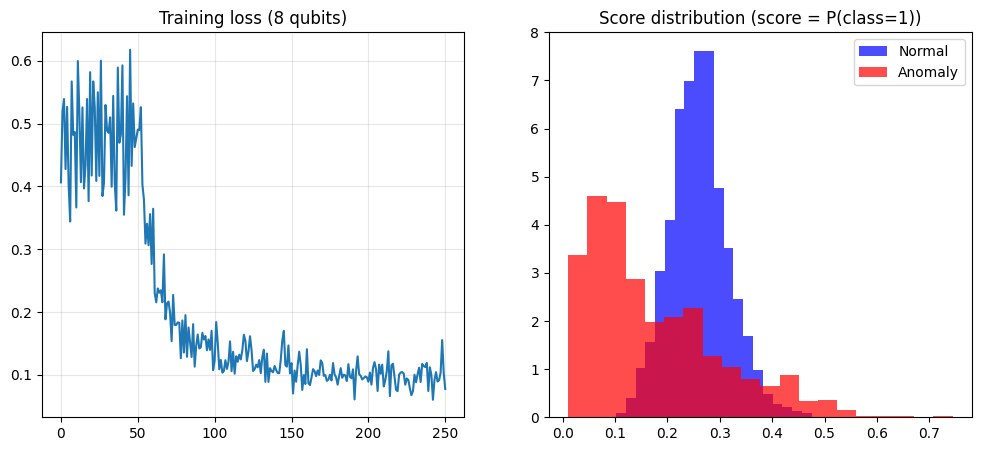

In [9]:
INPUT_DIM = N_DIM     # Teraz mamy 8 cech
MAX_ITER = 100     # Dajmy mu trochę czasu
BATCH_SIZE = 25 
EVAL_BATCH = 50

print(f">>> 1. Wczytywanie danych (8 cech)...")
try:
    train_data = np.load('train_data.npy')
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError as e:
    raise FileNotFoundError("BŁĄD: Nie znaleziono plików. Uruchom najpierw prepare_data.py z N_DIM=8!") from e

if train_data.ndim != 2:
    raise ValueError(f"""BŁĄD: train_data ma wymiar: {train_data.ndim}, 
                     oczekiwano macierzy 2D (n_samples, n_fueatures).""")
if train_data.shape[1] != INPUT_DIM:
    raise ValueError(f"""BŁĄD: Dane mają wymair: {train_data.shape[1]},
                     a kod oczekuje {INPUT_DIM}.""")

print(f"    Trening na: {len(train_data)} próbkach")

# --- OBWÓD KWANTOWY ---
print(">>> 2. Budowanie obwodu (8 kubitów)...")
feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')

qc = QuantumCircuit(INPUT_DIM)
qc.append(feature_map, range(INPUT_DIM))
qc.append(ansatz, range(INPUT_DIM))

def parity(x: int) -> int:
    return x % 2

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

# --- TRENING ---
objective_func_vals = []

def cost_func(params_values):
    BS = min(BATCH_SIZE, len(train_data))
    batch_idx = np.random.choice(len(train_data), BS, replace=False)
    batch_data = train_data[batch_idx]
    
    probs = qnn.forward(batch_data, params_values)
    p1 = np.clip(probs[:, 1], 1e-4, 1.0 - 1e-4)
    loss = float(np.mean(p1))

    objective_func_vals.append(loss)
    if len(objective_func_vals) % 10 == 0:
        print(f"    Iter {len(objective_func_vals)}: Koszt = {loss:.4f}")
    return loss

print(f">>> 3. Start treningu (Optimizer: SPSA, Iter: {MAX_ITER})...")

# --- ZMIANA TUTAJ ---
# COBYLA wyrzucamy:
# optimizer = COBYLA(maxiter=MAX_ITER) 

# Wstawiamy ADAM. 
# lr=0.01 to "learning rate". Jak wykres skacze jak szalony, zmniejsz do 0.001.
#optimizer = ADAM(maxiter=MAX_ITER, lr=0.01) 
optimizer = SPSA(maxiter=MAX_ITER)
initial_weights = 0.1 * (2 * np.random.random(ansatz.num_parameters) - 1)

start_t = time.time()
# ADAM wymaga gradientów, ale Qiskit SamplerQNN policzy je sobie sam (metodą różnic skończonych)
result = optimizer.minimize(fun=cost_func, x0=initial_weights)
print(f">>> Czas treningu: {time.time() - start_t:.1f} s")
print(f">>> Wyniki optymalizacji: fun={result.fun:.6f}")

# --- WYNIKI ---
print(">>> 4. Generowanie wyników...")
trained_weights = result.x

# Funkcja do ewaluacji (z batchem)
def get_scores_anomaly_prob(data):
    """ 
    Zwraca score = p1 (prawdopodobieństwo klasy 1 = 'anomaly' wg interpretacji QNN). 
    Jeśli etykietowanie jest odwrotne - zmienić na p[:, 0]
    """
    scores = []
    for i in range(0, len(data), EVAL_BATCH): # Mniejsze paczki dla 8 kubitów
        batch = data[i:i+EVAL_BATCH]
        p = qnn.forward(batch, trained_weights)
        p1 = p[:, 1]
        scores.extend(p1.tolist())
    return np.array(scores, dtype=float)

s_norm = get_scores_anomaly_prob(test_normal)
s_anom = get_scores_anomaly_prob(test_anomaly)

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(objective_func_vals)
plt.title(f"Training loss ({INPUT_DIM} qubits)")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(s_norm, bins=20, alpha=0.7, color='Blue', label='Normal', density=True)
plt.hist(s_anom, bins=20, alpha=0.7, color='Red', label='Anomaly', density=True)
plt.title("Score distribution (score = P(class=1))")
plt.legend()

plt.savefig("results_8qubits.png")
plt.show()

In [10]:
scores = np.concatenate([s_norm, s_anom])
y_true = np.array([0]*len(s_norm) + [1]*len(s_anom))

def best_threshold(rule="greater"):
    # rule="greater": anomaly jeśli score > t
    # rule="less": anomaly jeśli score < t
    ts = np.quantile(scores, np.linspace(0.01, 0.99, 200))
    best = (-1, None)
    for t in ts:
        if rule == "greater":
            y_pred = (scores > t).astype(int)
        else:
            y_pred = (scores < t).astype(int)
        acc = accuracy_score(y_true, y_pred)
        if acc > best[0]:
            best = (acc, t)
    return best

acc_g, t_g = best_threshold("greater")
acc_l, t_l = best_threshold("less")

print("Best rule score > t:", acc_g, "t =", t_g)
print("Best rule score < t:", acc_l, "t =", t_l)

print("Means:", "mean_norm=", np.mean(s_norm), "mean_anom=", np.mean(s_anom))


Best rule score > t: 0.5817929759704251 t = 0.3867217948969882
Best rule score < t: 0.7925138632162662 t = 0.16933573575781324
Means: mean_norm= 0.2608159872505333 mean_anom= 0.17322269225351797



>>> Generowanie Macierzy Pomyłek...
--- WYNIKI DLA PROGU 0.14 ---
Dokładność (Accuracy): 80.50%
Precyzja (Precision):  93.29% (Ile z wykrytych arytmii to faktycznie arytmie?)
Czułość (Recall):      60.58% (Ile z prawdziwych arytmii udało się wykryć?)


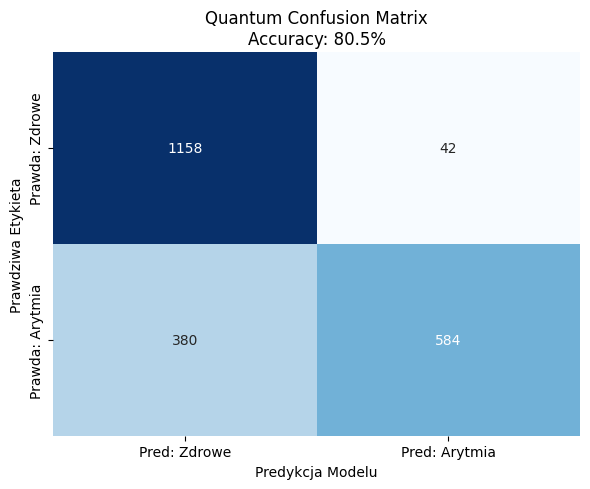

In [11]:
# =============================================
# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK
# =============================================

print("\n>>> Generowanie Macierzy Pomyłek...")

# 1. USTAWIENIE PROGU (THRESHOLD)
# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.
# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.
THRESHOLD = 0.14
THRESHOLD2 = 0.38

# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)
# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)
y_true = [0] * len(s_norm) + [1] * len(s_anom)

# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)
# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.
# Musimy odwrócić logikę:
# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)
# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)

y_pred = []
# Oceniamy zdrowe
for score in s_norm:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# Oceniamy chore
for score in s_anom:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# 4. OBLICZENIE METRYK
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"--- WYNIKI DLA PROGU {THRESHOLD} ---")
print(f"Dokładność (Accuracy): {acc:.2%}")
print(f"Precyzja (Precision):  {prec:.2%} (Ile z wykrytych arytmii to faktycznie arytmie?)")
print(f"Czułość (Recall):      {rec:.2%} (Ile z prawdziwych arytmii udało się wykryć?)")

# 5. RYSOWANIE ŁADNEJ MACIERZY (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Quantum Confusion Matrix\nAccuracy: {acc:.1%}')
plt.ylabel('Prawdziwa Etykieta')
plt.xlabel('Predykcja Modelu')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
# plt.show() # Zakomentowane, bo show() będzie na końcu głównego skryptu

In [8]:
"""# TWÓJ TOKEN
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A",
    overwrite=True,
    set_as_default=True
)
MY_TOKEN = "ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A" 

print("\n>>> 🚀 ROZPOCZYNAMY WALIDACJĘ NA IBM (TRYB JOB/V2)...")

# 1. Łączenie
service = QiskitRuntimeService(channel="ibm_quantum_platform", token=MY_TOKEN)
backend = service.least_busy(operational=True, simulator=False)
print(f"    Wybrano komputer: {backend.name}")
print(f"    Oczekujących zadań: {backend.status().pending_jobs}")

# 2. Przygotowanie danych (Batching)
# Używamy zmiennych z poprzedniej komórki (upewnij się, że KOMÓRKA 1 była uruchomiona!)
N_TEST = 20
data_normal = test_normal[:N_TEST]
data_anomaly = test_anomaly[:N_TEST]
combined_data = np.concatenate([data_normal, data_anomaly])

print(f"    Wysyłam {len(combined_data)} próbek jako JEDEN JOB...")

# =================================================================
# KROK KLUCZOWY: TRANSPILACJA (Tłumaczenie obwodu na język maszyny)
# =================================================================
print(">>> Transpilacja obwodu do układu bramek sprzętu (ISA)...")
# optimization_level=1 wystarczy, 3 dałoby krótszy obwód, ale trwa dłużej
qc_transpiled = transpile(qc, backend=backend, optimization_level=1)

# 3. Sampler V2
sampler_ibm = Sampler(mode=backend)
sampler_ibm.options.default_shots = 1024

# 4. Podpięcie QNN pod chmurę
# UWAGA: Tutaj podajemy 'circuit=qc_transpiled' zamiast zwykłego 'qc'
qnn_ibm = SamplerQNN(
    circuit=qc_transpiled,          # <--- TUTAJ ZMIANA
    input_params=feature_map.parameters, # Parametry zostają te same (Qiskit o to dba)
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2,
    sampler=sampler_ibm 
)

# 5. Wykonanie
print(">>> Czekanie na wynik z IBM Quantum (to chwilę potrwa)...")
try:
    job_result = qnn_ibm.forward(combined_data, trained_weights)
    all_scores = job_result[:, 1]
    
    print(">>> JOB UKOŃCZONY! Wyniki pobrane.")

    # 6. Rozdzielenie i Wizualizacja
    scores_ibm_norm = all_scores[:N_TEST]
    scores_ibm_anom = all_scores[N_TEST:]

    plt.figure(figsize=(8, 6))
    plt.hist(scores_ibm_norm, bins=10, alpha=0.7, color='blue', label='IBM Normal', density=True)
    plt.hist(scores_ibm_anom, bins=10, alpha=0.7, color='red', label='IBM Anomaly', density=True)
    plt.title(f"Walidacja na Prawdziwym Procesorze: {backend.name}")
    plt.xlabel("Błąd rekonstrukcji")
    plt.legend()
    plt.savefig("ibm_real_results.png")
    plt.show()

except Exception as e:
    print(f"\nWYSTĄPIŁ BŁĄD PODCZAS PRZETWARZANIA: {e}")
    print("Wskazówka: Jeśli błąd dotyczy limitów użycia, spróbuj zmniejszyć N_TEST do 10.")"""

'# TWÓJ TOKEN\nQiskitRuntimeService.save_account(\n    channel="ibm_quantum_platform",\n    token="ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A",\n    overwrite=True,\n    set_as_default=True\n)\nMY_TOKEN = "ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A" \n\nprint("\n>>> 🚀 ROZPOCZYNAMY WALIDACJĘ NA IBM (TRYB JOB/V2)...")\n\n# 1. Łączenie\nservice = QiskitRuntimeService(channel="ibm_quantum_platform", token=MY_TOKEN)\nbackend = service.least_busy(operational=True, simulator=False)\nprint(f"    Wybrano komputer: {backend.name}")\nprint(f"    Oczekujących zadań: {backend.status().pending_jobs}")\n\n# 2. Przygotowanie danych (Batching)\n# Używamy zmiennych z poprzedniej komórki (upewnij się, że KOMÓRKA 1 była uruchomiona!)\nN_TEST = 20\ndata_normal = test_normal[:N_TEST]\ndata_anomaly = test_anomaly[:N_TEST]\ncombined_data = np.concatenate([data_normal, data_anomaly])\n\nprint(f"    Wysyłam {len(combined_data)} próbek jako JEDEN JOB...")\n\n# ================================================

In [9]:
"""# =============================================
# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK
# =============================================

print("\n>>> Generowanie Macierzy Pomyłek...")

# 1. USTAWIENIE PROGU (THRESHOLD)
# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.
# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.
THRESHOLD = 0.14

# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)
# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)
y_true = [0] * len(scores_ibm_norm) + [1] * len(scores_ibm_anom)

# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)
# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.
# Musimy odwrócić logikę:
# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)
# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)

y_pred = []
# Oceniamy zdrowe
for score in scores_ibm_norm:
    prediction = 1 if score < THRESHOLD else 0
    y_pred.append(prediction)

# Oceniamy chore
for score in scores_ibm_anom:
    prediction = 1 if score < THRESHOLD else 0
    y_pred.append(prediction)

# 4. OBLICZENIE METRYK
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"--- WYNIKI DLA PROGU {THRESHOLD} ---")
print(f"Dokładność (Accuracy): {acc:.2%}")
print(f"Precyzja (Precision):  {prec:.2%} (Ile z wykrytych arytmii to faktycznie arytmie?)")
print(f"Czułość (Recall):      {rec:.2%} (Ile z prawdziwych arytmii udało się wykryć?)")

# 5. RYSOWANIE ŁADNEJ MACIERZY (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Quantum Confusion Matrix\nAccuracy: {acc:.1%}')
plt.ylabel('Prawdziwa Etykieta')
plt.xlabel('Predykcja Modelu')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
# plt.show() # Zakomentowane, bo show() będzie na końcu głównego skryptu"""

'# =============================================\n# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK\n# =============================================\n\nprint("\n>>> Generowanie Macierzy Pomyłek...")\n\n# 1. USTAWIENIE PROGU (THRESHOLD)\n# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.\n# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.\nTHRESHOLD = 0.14\n\n# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)\n# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)\ny_true = [0] * len(scores_ibm_norm) + [1] * len(scores_ibm_anom)\n\n# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)\n# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.\n# Musimy odwrócić logikę:\n# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)\n# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)\n\ny_pred = []\n# Oceniamy zdrowe\nfor score in scores_ibm_norm:\n    prediction = 1 if score < THRESHOLD else 0\n    y_pred.append(prediction)\n\n# Ocenia

# Analiza skalowalności

In [21]:
import warnings
from sklearn.metrics import roc_auc_score, confusion_matrix
import time
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore", category=DeprecationWarning)

def scores_from_qnn(qnn, weights, X, eval_batch=50):
    scores = []
    for i in range(0, len(X), eval_batch):
        p = qnn.forward(X[i:i+eval_batch], weights)  # (BS,2)
        p0 = np.clip(p[:, 0], 1e-6, 1-1e-6)
        scores.extend((1.0 - p0).tolist())           # score = 1 - P(normal)
    return np.array(scores, dtype=float)

def threshold_from_norm(scores_norm, fpr_target=0.05):
    # threshold = 95 percentyl normalnych -> ~5% FPR
    return float(np.quantile(scores_norm, 1.0 - fpr_target))

def tpr_fpr_cm(scores_norm, scores_anom, thr):
    y_true = np.array([0]*len(scores_norm) + [1]*len(scores_anom))
    scores = np.concatenate([scores_norm, scores_anom])
    y_pred = (scores > thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn + 1e-12)
    fpr = fp / (fp + tn + 1e-12)
    return tpr, fpr, cm


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import SPSA

def run_one_setting(train_patients, test_patients, limit_per_patient,
                    n_dim=8, reps_ansatz=1,
                    max_iter=120, batch_size=25, eval_batch=50,
                    fpr_target=0.05, seed=0):

    # --- Ustaw globalny LIMIT_PER_PATIENT na czas tego runa (bo loader go używa) ---
    global LIMIT_PER_PATIENT
    old_limit = LIMIT_PER_PATIENT
    LIMIT_PER_PATIENT = limit_per_patient

    try:
        # --- LOAD: train normal only ---
        X_train_list = []
        for pid in train_patients:
            n, _ = load_patient_data(pid)
            X_train_list.extend(n)
        X_train = np.array(X_train_list)

        # --- LOAD: test normal + anomaly ---
        Xn_list, Xa_list = [], []
        for pid in test_patients:
            n, a = load_patient_data(pid)
            Xn_list.extend(n)
            Xa_list.extend(a)
        X_test_normal = np.array(Xn_list)
        X_test_anom = np.array(Xa_list)

        if len(X_train) == 0 or len(X_test_normal) == 0 or len(X_test_anom) == 0:
            return None  # pomiń nieudane ustawienia

        # --- PCA fit on train normal ---
        pca = PCA(n_components=n_dim, random_state=seed)
        X_train_pca = pca.fit_transform(X_train)
        Xn_pca = pca.transform(X_test_normal)
        Xa_pca = pca.transform(X_test_anom)
        explained = float(np.sum(pca.explained_variance_ratio_) * 100.0)

        # --- scaling to (0, pi) fit on train normal ---
        scaler = MinMaxScaler(feature_range=(0, np.pi))
        X_train_q = scaler.fit_transform(X_train_pca)
        Xn_q = scaler.transform(Xn_pca)
        Xa_q = scaler.transform(Xa_pca)

        # --- Build QNN (simulator only via SamplerQNN internal sampling) ---
       

        feature_map = PauliFeatureMap(
            feature_dimension=INPUT_DIM,
            reps=2,
            paulis=["Z", "ZZ"]
        )

        ansatz = RealAmplitudes(num_qubits=n_dim, reps=reps_ansatz, entanglement='linear')

        qc = QuantumCircuit(n_dim)
        qc.append(feature_map, range(n_dim))
        qc.append(ansatz, range(n_dim))

        def parity(x: int) -> int:
            return x % 2

        qnn = SamplerQNN(
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            interpret=parity,
            output_shape=2
        )

        # --- Loss: NLL on normal class with mild confidence regularization ---
        
        
        objective_func_vals = []
        rng = np.random.default_rng(0)   # reprodukowalność

        def cost_func(params_values):
            BS = min(BATCH_SIZE, len(X_train_q))
            batch_idx = rng.choice(len(X_train_q), BS, replace=False)
            batch_data = X_train_q[batch_idx]

            probs = qnn.forward(batch_data, params_values)   # (BS, 2)
            p0 = np.clip(probs[:, 0], 1e-6, 1.0 - 1e-6)      # P(normal)

            scores = 1.0 - p0  # im większy, tym "bardziej anomalne" (dla normalnych chcemy małe)

            q95 = float(np.quantile(scores, 0.95))           # kontrola ogona ~ FPR 5%
            loss = q95 + 0.10 * float(np.mean(scores))       # stabilizator

            objective_func_vals.append(loss)
            if len(objective_func_vals) % 10 == 0:
                print(f"Iter {len(objective_func_vals)} | Loss={loss:.6f} | q95={q95:.6f} | mean={float(np.mean(scores)):.6f}")
            return loss



        optimizer = SPSA(
            maxiter=MAX_ITER,
            learning_rate=0.01,   # stabilne dla SamplerQNN
            perturbation=0.05
        )
    
        x0 = 0.1 * (2 * rng.random(ansatz.num_parameters) - 1)

        t0 = time.time()
        res = optimizer.minimize(fun=cost_func, x0=x0)
        train_time = time.time() - t0

        weights = res.x

        # --- Eval ---
        s_norm = scores_from_qnn(qnn, weights, Xn_q, eval_batch=eval_batch)
        s_anom = scores_from_qnn(qnn, weights, Xa_q, eval_batch=eval_batch)

        auc = float(roc_auc_score(
            np.array([0]*len(s_norm) + [1]*len(s_anom)),
            np.concatenate([s_norm, s_anom])
        ))

        thr = threshold_from_norm(s_norm, fpr_target=fpr_target)
        tpr, fpr, cm = tpr_fpr_cm(s_norm, s_anom, thr)

        return {
            "train_patients": ",".join(train_patients),
            "test_patients": ",".join(test_patients),
            "limit_per_patient": limit_per_patient,
            "train_normal": len(X_train_q),
            "test_normal": len(Xn_q),
            "test_anomaly": len(Xa_q),
            "pca_explained_%": explained,
            "roc_auc": auc,
            "tpr@fpr": tpr,
            "fpr": fpr,
            "threshold": thr,
            "train_time_s": train_time,
            "iters": len(objective_func_vals),
            "final_loss": float(objective_func_vals[-1]) if objective_func_vals else np.nan,
            "reps_ansatz": reps_ansatz
        }

    finally:
        LIMIT_PER_PATIENT = old_limit  # przywróć


### Feature Stacking

In [23]:
def view_raw(X):
    return X

def view_diff(X):
    d = np.diff(X, axis=1)
    d = np.concatenate([d, d[:, -1:]], axis=1)  # padding, żeby zachować WINDOW_SIZE
    return d

VIEWS = {
    "raw": view_raw,
    "diff": view_diff,
}

def preprocess_pca_scale(X_train, X_test_n, X_test_a, n_dim, seed=0):
    pca = PCA(n_components=n_dim, random_state=seed)
    Xtr = pca.fit_transform(X_train)
    Xn  = pca.transform(X_test_n)
    Xa  = pca.transform(X_test_a)
    explained = float(np.sum(pca.explained_variance_ratio_) * 100.0)

    scaler = MinMaxScaler(feature_range=(0, np.pi))
    Xtr_s = scaler.fit_transform(Xtr)
    Xn_s  = scaler.transform(Xn)
    Xa_s  = scaler.transform(Xa)
    return Xtr_s, Xn_s, Xa_s, explained

def run_one_setting_stacking(train_patients, test_patients, limit_per_patient,
                             n_dim=8, reps_ansatz=1,
                             max_iter=120, batch_size=25, eval_batch=50,
                             fpr_target=0.05, seed=0,
                             views=("raw","diff")):

    global LIMIT_PER_PATIENT
    old_limit = LIMIT_PER_PATIENT
    LIMIT_PER_PATIENT = limit_per_patient

    try:
        # --- LOAD: train normal only ---
        X_train_list = []
        for pid in train_patients:
            n, _ = load_patient_data(pid)
            X_train_list.extend(n)
        X_train = np.array(X_train_list)

        # --- LOAD: test normal + anomaly ---
        Xn_list, Xa_list = [], []
        for pid in test_patients:
            n, a = load_patient_data(pid)
            Xn_list.extend(n)
            Xa_list.extend(a)
        X_test_normal = np.array(Xn_list)
        X_test_anom   = np.array(Xa_list)

        if len(X_train)==0 or len(X_test_normal)==0 or len(X_test_anom)==0:
            return None

        # --- per-view training + scoring ---
        scores_norm_views = []
        scores_anom_views = []
        explained_views = []
        train_times = []
        final_losses = []

        for vname in views:
            f = VIEWS[vname]
            Xtr_v = f(X_train)
            Xn_v  = f(X_test_normal)
            Xa_v  = f(X_test_anom)

            X_train_q, Xn_q, Xa_q, explained = preprocess_pca_scale(
                Xtr_v, Xn_v, Xa_v, n_dim=n_dim, seed=seed
            )
            explained_views.append(explained)

            # --- Build QNN ---
            feature_map = PauliFeatureMap(
                feature_dimension=n_dim,
                reps=2,
                paulis=["Z", "ZZ"]
            )
            ansatz = RealAmplitudes(num_qubits=n_dim, reps=reps_ansatz, entanglement='linear')

            qc = QuantumCircuit(n_dim)
            qc.append(feature_map, range(n_dim))
            qc.append(ansatz, range(n_dim))

            def parity(x: int) -> int:
                return x % 2

            qnn = SamplerQNN(
                circuit=qc,
                input_params=feature_map.parameters,
                weight_params=ansatz.parameters,
                interpret=parity,
                output_shape=2
            )

            rng = np.random.default_rng(seed + (0 if vname=="raw" else 1337))
            objective_func_vals = []

            def cost_func(params_values):
                BS = min(batch_size, len(X_train_q))
                idx = rng.choice(len(X_train_q), BS, replace=False)
                batch = X_train_q[idx]

                probs = qnn.forward(batch, params_values)
                p0 = np.clip(probs[:, 0], 1e-6, 1-1e-6)
                scores = 1.0 - p0
                q95 = float(np.quantile(scores, 0.95))
                loss = q95 + 0.10 * float(np.mean(scores))

                objective_func_vals.append(loss)
                return float(loss)

            optimizer = SPSA(
                maxiter=max_iter,
                learning_rate=0.01,
                perturbation=0.05
            )

            x0 = 0.1 * (2 * rng.random(ansatz.num_parameters) - 1)

            t0 = time.time()
            res = optimizer.minimize(fun=cost_func, x0=x0)
            t1 = time.time()

            weights = res.x
            train_times.append(t1 - t0)
            final_losses.append(float(objective_func_vals[-1]) if objective_func_vals else np.nan)

            # 1) score na train normal do kalibracji orientacji
            s_train = scores_from_qnn(qnn, weights, X_train_q, eval_batch=eval_batch)

# lepsze kryterium niż median: użyj q95 (spójne z tail-loss)
            flip = (float(np.quantile(s_train, 0.95)) > 0.5)

# 2) score na test
            s_norm = scores_from_qnn(qnn, weights, Xn_q, eval_batch=eval_batch)
            s_anom = scores_from_qnn(qnn, weights, Xa_q, eval_batch=eval_batch)

# 3) zastosuj flip przed dodaniem do ensemble
            if flip:
                s_norm = 1.0 - s_norm
                s_anom = 1.0 - s_anom

            scores_norm_views.append(s_norm)
            scores_anom_views.append(s_anom)



        # --- ensemble average ---
        # --- ensemble aggregation (supports 1+ views) ---
        W = np.ones(len(scores_norm_views), dtype=float)
        W = W / W.sum()  # równe wagi domyślnie

        s_norm_ens = np.zeros_like(scores_norm_views[0])
        s_anom_ens = np.zeros_like(scores_anom_views[0])

        for w, sn, sa in zip(W, scores_norm_views, scores_anom_views):
            s_norm_ens += w * sn
            s_anom_ens += w * sa


        
        auc = float(roc_auc_score(
            np.array([0]*len(s_norm_ens) + [1]*len(s_anom_ens)),
            np.concatenate([s_norm_ens, s_anom_ens])
        ))

        thr = threshold_from_norm(s_norm_ens, fpr_target=fpr_target)
        tpr, fpr, cm = tpr_fpr_cm(s_norm_ens, s_anom_ens, thr)
        print("mean(score) normal:", float(np.mean(s_norm_ens)))
        print("mean(score) anom  :", float(np.mean(s_anom_ens)))
        print("median(score) normal:", float(np.median(s_norm_ens)))
        print("median(score) anom  :", float(np.median(s_anom_ens)))
        return {
            "train_patients": ",".join(train_patients),
            "test_patients": ",".join(test_patients),
            "limit_per_patient": limit_per_patient,
            "train_normal": len(X_train),
            "test_normal": len(X_test_normal),
            "test_anomaly": len(X_test_anom),
            "views": ",".join(views),
            "pca_explained_%": float(np.mean(explained_views)),
            "roc_auc": auc,
            "tpr@fpr": tpr,
            "fpr": fpr,
            "threshold": thr,
            "train_time_s": float(np.sum(train_times)),
            "final_loss": float(np.mean(final_losses)),
            "reps_ansatz": reps_ansatz
        }

    finally:
        LIMIT_PER_PATIENT = old_limit


Sanity check

In [24]:
out = run_one_setting_stacking(
    train_patients=["100","101","102"],
    test_patients=["106","119"],
    limit_per_patient=200,
    n_dim=N_DIM,
    reps_ansatz=1,
    max_iter=100,
    batch_size=25,
    eval_batch=50,
    fpr_target=0.05,
    seed=0,
    views=("diff",)
)
out


  -> Znaleziono: 200 Normal, 34 Anomaly
  -> Znaleziono: 200 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 200 Anomaly
  -> Znaleziono: 200 Normal, 200 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 200 Normal, 200 Anomaly
mean(score) normal: 0.49883094081300894
mean(score) anom  : 0.5873032626800295
median(score) normal: 0.49993156192431343
median(score) anom  : 0.5230681519851714


{'train_patients': '100,101,102',
 'test_patients': '106,119',
 'limit_per_patient': 200,
 'train_normal': 499,
 'test_normal': 400,
 'test_anomaly': 400,
 'views': 'diff',
 'pca_explained_%': 89.92436178539202,
 'roc_auc': 0.7696812500000001,
 'tpr@fpr': np.float64(0.4599999999999988),
 'fpr': np.float64(0.04999999999999987),
 'threshold': 0.5346069798404641,
 'train_time_s': 82.51355290412903,
 'final_loss': 0.5796831877548757,
 'reps_ansatz': 1}

In [25]:
TRAIN_PATIENT_SETS = [
    ["100"],
    ["100","101"],
    ["100","101","102"],
    ["100","101","102","103","104"],
]

TEST_PATIENTS_FIXED = ["106","119"]

LIMIT_GRID = [100, 200, 400, 600]

rows = []
exp_id = 0

for train_set in TRAIN_PATIENT_SETS:
    for limit_val in LIMIT_GRID:
        out = run_one_setting_stacking(
            train_patients=train_set,
            test_patients=TEST_PATIENTS_FIXED,
            limit_per_patient=limit_val,
            n_dim=N_DIM,
            reps_ansatz=1,      # możesz zrobić drugi przebieg z reps=2
            max_iter=120,
            batch_size=25,
            eval_batch=50,
            fpr_target=0.05,
            seed=0,
            views = ("diff",)
        )
        if out is None:
            continue
        out["ID"] = exp_id
        rows.append(out)
        exp_id += 1

df = pd.DataFrame(rows).sort_values(["train_patients","limit_per_patient"])
df


  -> Znaleziono: 100 Normal, 34 Anomaly
  -> Znaleziono: 100 Normal, 100 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 100 Normal, 100 Anomaly
mean(score) normal: 0.5109964704487993
mean(score) anom  : 0.4997056690951831
median(score) normal: 0.49735725035498035
median(score) anom  : 0.49858668848173693
  -> Znaleziono: 200 Normal, 34 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 200 Normal, 200 Anomaly
  -> Znaleziono: 200 Normal, 200 Anomaly
mean(score) normal: 0.5395961450675532
mean(score) anom  : 0.4974703457394435
median(score) normal: 0.5067138858494218
median(score) anom  : 0.5004967736713297
  -> Znaleziono: 400 Normal, 34 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 400 Normal, 400 Anomaly
  -> Znaleziono: 400 Normal, 400 Anomaly
mean(score) normal: 0.5283489106520733
mean(score) anom  : 0.501440442718117
median(score) normal: 0.4990051731956555
median(score) anom  : 0.49971009513228637
  -> Znaleziono: 600 Normal, 34 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly
mean(score) normal: 0.4993250148620427
mean(score) anom  : 0.5006330926913276
median(score) normal: 0.5002199066457251
median(score) anom  : 0.4998457313486142
  -> Znaleziono: 100 Normal, 34 Anomaly
  -> Znaleziono: 100 Normal, 3 Anomaly
  -> Znaleziono: 100 Normal, 100 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 100 Normal, 100 Anomaly
mean(score) normal: 0.5001073979328976
mean(score) anom  : 0.5621211908501573
median(score) normal: 0.4991925161830295
median(score) anom  : 0.5053940279067319
  -> Znaleziono: 200 Normal, 34 Anomaly
  -> Znaleziono: 200 Normal, 3 Anomaly
  -> Znaleziono: 200 Normal, 200 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 200 Normal, 200 Anomaly
mean(score) normal: 0.4985786364232808
mean(score) anom  : 0.5081944654152494
median(score) normal: 0.4996165609345553
median(score) anom  : 0.5010007581113314
  -> Znaleziono: 400 Normal, 34 Anomaly
  -> Znaleziono: 400 Normal, 3 Anomaly
  -> Znaleziono: 400 Normal, 400 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 400 Normal, 400 Anomaly
mean(score) normal: 0.49911395622951205
mean(score) anom  : 0.5011937052866461
median(score) normal: 0.4996640312956515
median(score) anom  : 0.5007559188161395
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 600 Normal, 520 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 600 Normal, 444 Anomaly
mean(score) normal: 0.5000168143716777
mean(score) anom  : 0.5019758324412382
median(score) normal: 0.500099295032669
median(score) anom  : 0.49962581971522013
  -> Znaleziono: 100 Normal, 34 Anomaly
  -> Znaleziono: 100 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 100 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 100 Normal, 100 Anomaly
  -> Znaleziono: 100 Normal, 100 Anomaly
mean(score) normal: 0.5013291706853125
mean(score) anom  : 0.5486961776383122
median(score) normal: 0.4997826053013341
median(score) anom  : 0.5006919540055605
  -> Znaleziono: 200 Normal, 34 Anomaly
  -> Znaleziono: 200 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 200 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 200 Normal, 200 Anomaly
  -> Znaleziono: 200 Normal, 200 Anomaly
mean(score) normal: 0.49848221090299377
mean(score) anom  : 0.5867771545045207
median(score) normal: 0.4995935017686861
median(score) anom  : 0.5241616703833643
  -> Znaleziono: 400 Normal, 34 Anomaly
  -> Znaleziono: 400 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 400 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 400 Normal, 400 Anomaly
  -> Znaleziono: 400 Normal, 400 Anomaly
mean(score) normal: 0.49993183225391247
mean(score) anom  : 0.64313646142871
median(score) normal: 0.49999930176454654
median(score) anom  : 0.5763851363462891
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly
mean(score) normal: 0.49859376555927154
mean(score) anom  : 0.5249721332942107
median(score) normal: 0.49985500256843807
median(score) anom  : 0.5024935773135439
  -> Znaleziono: 100 Normal, 34 Anomaly
  -> Znaleziono: 100 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 100 Anomaly
  -> Znaleziono: 100 Normal, 2 Anomaly
  -> Znaleziono: 100 Normal, 100 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 100 Normal, 100 Anomaly
  -> Znaleziono: 100 Normal, 100 Anomaly
mean(score) normal: 0.5004718383834097
mean(score) anom  : 0.5920439348737091
median(score) normal: 0.5001041566356434
median(score) anom  : 0.5224844504436987
  -> Znaleziono: 200 Normal, 34 Anomaly
  -> Znaleziono: 200 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 200 Anomaly
  -> Znaleziono: 200 Normal, 2 Anomaly
  -> Znaleziono: 163 Normal, 200 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 200 Normal, 200 Anomaly
  -> Znaleziono: 200 Normal, 200 Anomaly
mean(score) normal: 0.5010530425676734
mean(score) anom  : 0.5535004973999048
median(score) normal: 0.5013553878525272
median(score) anom  : 0.5033874265936902
  -> Znaleziono: 400 Normal, 34 Anomaly
  -> Znaleziono: 400 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 400 Anomaly
  -> Znaleziono: 400 Normal, 2 Anomaly
  -> Znaleziono: 163 Normal, 400 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 400 Normal, 400 Anomaly
  -> Znaleziono: 400 Normal, 400 Anomaly
mean(score) normal: 0.5030518797214382
mean(score) anom  : 0.5473901219995809
median(score) normal: 0.49959794604728813
median(score) anom  : 0.5017555753147462
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly
  -> Znaleziono: 600 Normal, 2 Anomaly
  -> Znaleziono: 163 Normal, 600 Anomaly


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly
mean(score) normal: 0.49549562651310075
mean(score) anom  : 0.5181533509844692
median(score) normal: 0.4997723368451261
median(score) anom  : 0.49886665238500427


,train_patients,test_patients,limit_per_patient,train_normal,test_normal,test_anomaly,views,pca_explained_%,roc_auc,tpr@fpr,fpr,threshold,train_time_s,final_loss,reps_ansatz,ID
0,100,"106,119",100,100,200,200,diff,87.494641,0.533075,0.005000,0.05,0.726620,100.024263,0.581553,1,0
1,100,"106,119",200,200,400,400,diff,87.247811,0.340175,0.002500,0.05,0.809218,100.318925,0.575960,1,1
2,100,"106,119",400,400,800,800,diff,87.101690,0.511334,0.005000,0.05,0.854839,100.712949,0.563918,1,2
3,100,"106,119",600,600,1200,964,diff,87.170150,0.488859,0.089212,0.05,0.529397,100.379318,0.572206,1,3
4,"100,101","106,119",100,200,200,200,diff,89.025775,0.730000,0.400000,0.05,0.515976,99.864151,0.550920,1,4
5,"100,101","106,119",200,400,400,400,diff,85.935461,0.587181,0.050000,0.05,0.522146,98.709853,0.575722,1,5
6,"100,101","106,119",400,800,800,800,diff,88.297698,0.561764,0.021250,0.05,0.528860,99.822060,0.558175,1,6
7,"100,101","106,119",600,1200,1200,964,diff,89.579917,0.484743,0.035270,0.05,0.533079,124.409620,0.554905,1,7
8,"100,101,102","106,119",100,299,200,200,diff,92.735236,0.593050,0.210000,0.05,0.539752,124.542454,0.571746,1,8
9,"100,101,102","106,119",200,499,400,400,diff,89.924362,0.762519,0.460000,0.05,0.536715,138.586167,0.608928,1,9
